In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/home/david/data/searchingfornues/v08_00_00_25/cc0pinp/1205/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
SHRCALIBFACTOR = 1.00

In [4]:
# Doing Run3?
ISRUN3 = False

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [6]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [9]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

NUE = "allnues"

#if ISRUN3:
#    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'
#    
#else:
#    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2'
    
UPROOTNUE = uproot.open(ls.ntuple_path+NUE+".root")[fold][tree]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "NeutrinoEnergy2",
    "run","sub","evt",
    "CosmicIP",
    "nu_flashmatch_score",
    "isVtxInFiducial","truthFiducial","nproton",
    "elec_e","proton_e",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist0","trkshrhitdist1","trkshrhitdist2", # distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "pi0_gammadot","pi0_mass_Y","pi0_energy2_Y", # pi0 tagger variables
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "pi0_mass_Y", "pi0_gammadot",
    # second-shower tagging variables
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "secondshower_V_nhit","secondshower_V_vtxdist","secondshower_V_dot","secondshower_V_dir","shrclusdir1",
    "secondshower_U_nhit","secondshower_U_vtxdist","secondshower_U_dot","secondshower_U_dir","shrclusdir0",
    #
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",# gap10 dedx
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y"# 2cm dedx
]

nue = UPROOTNUE.pandas.df(variables, flatten=False)

In [10]:
def EQE(df,elecangle,elecenergy,corr):
    mp = 0.998
    mn = 0.939
    Eb = 0.00987 # see DocDB 26949
    theta = df[elecangle]
    El = df[elecenergy]/corr
    num = mp**2 - (mn-Eb)**2 + 2*(mn-Eb)*El
    den = 2*(mn-Eb-El*(1-np.cos(theta)))
    return num/den

In [14]:
# define some energy-related variables
# calorimetric energy [shower + all tracks as protons]
nue["reco_e_calo"] = (nue["shr_energy_tot_cali"]) / 0.79 + nue["trk_energy_tot"]
# calorimetric energy using truth-level information
nue["reco_e_calo_truth"] = nue["elec_e"] + nue["trk_energy_tot"]
# CCQE energy with lepton
nue['reco_e_qe'] = EQE(nue,'shr_theta','shr_energy_tot_cali',0.8)
# CCQE energy with truth lepton information
nue['reco_e_qe_truth'] = EQE(nue,'shr_theta','elec_e',1.0)
#nue["reco_e_qe"] = 0.938*((nue["shr_energy_tot_cali"])/0.79)/(0.938 - ((nue["shr_energy_tot_cali"]+0.030)/0.79)*(1-np.cos(nue["shr_theta"])))
#nue["reco_e_rqe"] = nue["reco_e_qe"]/nue["reco_e"]

In [15]:
nue['anglediff_Y'] = np.abs(nue['secondshower_Y_dir']-nue['shrclusdir2'])
nue['anglediff_V'] = np.abs(nue['secondshower_V_dir']-nue['shrclusdir1'])
nue['anglediff_U'] = np.abs(nue['secondshower_U_dir']-nue['shrclusdir0'])

In [16]:
trk_llr_pid_v = UPROOTNUE.array('trk_llr_pid_score_v')
trk_id = UPROOTNUE.array('trk_id')-1 # I think we need this -1 to get the right result
trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
nue['trkpid'] = trk_llr_pid_v_sel
nue['subcluster'] = nue['shrsubclusters0'] + nue['shrsubclusters1'] + nue['shrsubclusters2']
nue['trkfit'] = nue['shr_tkfit_npointsvalid'] / nue['shr_tkfit_npoints']

In [17]:
#mc_px_v = UPROOTNUE.array('mc_px')
#mc_py_v = UPROOTNUE.array('mc_py')
#mc_pz_v = UPROOTNUE.array('mc_pz')
#mc_pdg = UPROOTNUE.array('mc_pdg')-1 # I think we need this -1 to get the right result
#mc_px_elec = awkward.fromiter([mcv[tid] if tid<len(mcv) else 9999. for mcv,tid in zip(mc_px_v,mc_pdg)])
#nue['trkpid'] = trk_llr_pid_v_sel
#nue['subcluster'] = nue['shrsubclusters0'] + nue['shrsubclusters1'] + nue['shrsubclusters2']
#nue['trkfit'] = nue['shr_tkfit_npointsvalid'] / nue['shr_tkfit_npoints']

In [18]:
nue["is_signal"] = nue["category"] == 11

In [26]:
# energy resolution for calorimetric energy
nue['erescalo'] = (nue['reco_e_calo']-nue['nu_e'])/nue['nu_e']
# energy resolution for calorimetric energy vs. visible energy
nue['erescalovis'] = (nue['reco_e_calo']-nue['true_e_visible'])/nue['true_e_visible']
# energy resolution for QE energy
nue['eresqe'] = (nue['reco_e_qe']-nue['nu_e'])/nue['nu_e']
nue['eresqetruth'] = (nue['reco_e_qe_truth']-nue['nu_e'])/nue['nu_e']
# energy resolution for QE energy vs. visible energy
nue['eresqevis'] = (nue['reco_e_qe']-nue['true_e_visible'])/nue['true_e_visible']
# energy resolution for shower
nue['shrres'] = (((nue['shr_energy_tot_cali'])/0.79)-nue['elec_e'])/nue['elec_e']
# energy resolution for proton
nue['protonres'] = (nue['trk_energy']-(nue['proton_e']-0.938))/(nue['proton_e']-0.938)

In [27]:
QUERY = 'nslice == 1'
QUERY += ' and selected == 1'
QUERY += ' and n_tracks_contained > 0'
QUERY += ' and shr_energy_tot_cali > 0.07'
#QUERY += ' and trkpid < -0.02'

print (QUERY)

nslice == 1 and selected == 1 and n_tracks_contained > 0 and shr_energy_tot_cali > 0.07


In [28]:
nue_SEL = nue.query(QUERY)

In [29]:
nueRES = nue_SEL.query('interaction == 1')
nueQE  = nue_SEL.query('interaction == 0')
nueDIS = nue_SEL.query('interaction == 2')
nueMEC = nue_SEL.query('interaction == 10')

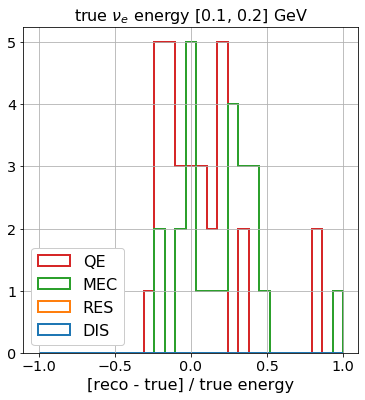

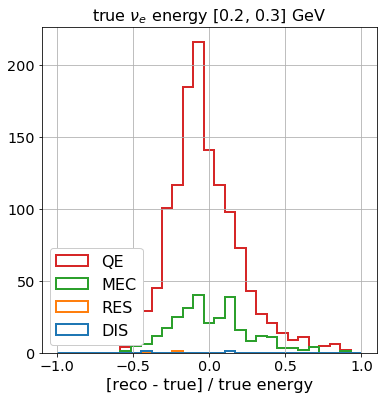

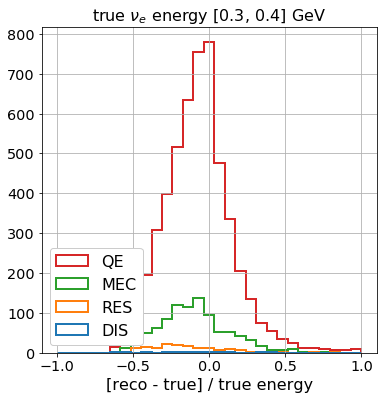

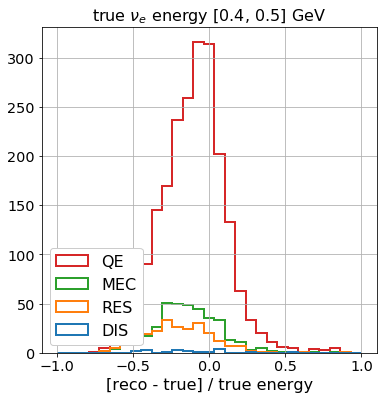

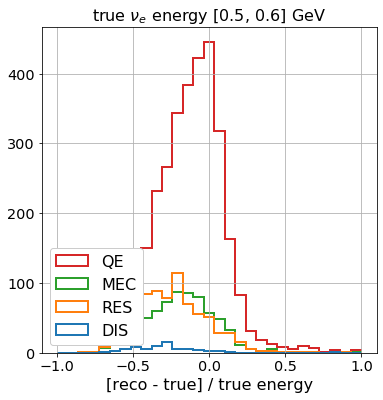

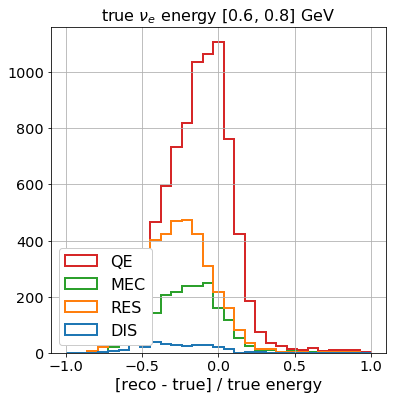

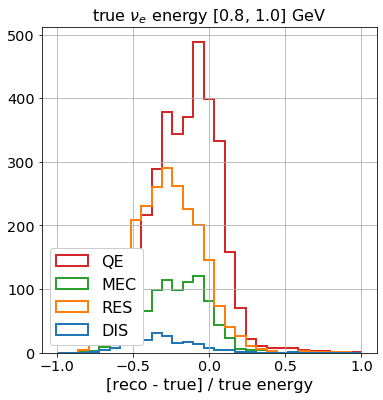

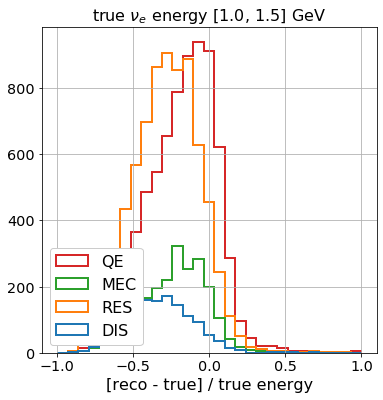

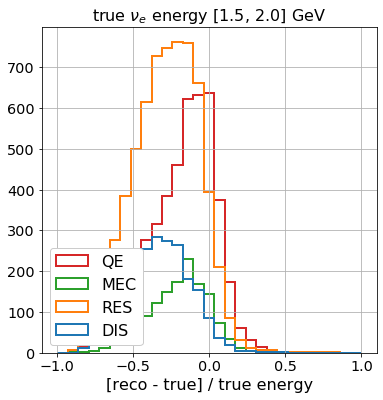

In [39]:
ERANGE_V = []

ERANGE_V = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0,1.5,2.0]


for n in range(len(ERANGE_V)-1):
    
    EMIN = ERANGE_V[n]
    EMAX = ERANGE_V[n+1]
    
    stacked_v = []
    
    VAR = 'erescalo'

    nueQE_tmp = nueQE.query('nu_e > %f and nu_e < %f'%(EMIN,EMAX))
    nueRES_tmp = nueRES.query('nu_e > %f and nu_e < %f'%(EMIN,EMAX))
    nueMEC_tmp = nueMEC.query('nu_e > %f and nu_e < %f'%(EMIN,EMAX))
    nueDIS_tmp = nueDIS.query('nu_e > %f and nu_e < %f'%(EMIN,EMAX))
    
    stacked_v = [nueDIS_tmp[VAR],nueRES_tmp[VAR],\
                 nueMEC_tmp[VAR],nueQE_tmp[VAR]]

    label_v = ['DIS','RES','MEC','QE']
    
    fig = plt.figure(figsize=(6,6))
    BINS = np.linspace(-1,1,30)
    plt.hist(stacked_v,bins=BINS,histtype='step',lw=2,label=label_v,stacked=False)
    plt.grid()
    plt.legend(loc=3,framealpha=1,fontsize=16)
    plt.xlabel('[reco - true] / true energy',fontsize=16)
    plt.title(r'true $\nu_e$ energy [%.01f, %.01f] GeV'%(EMIN,EMAX),fontsize=16)
    plt.show()

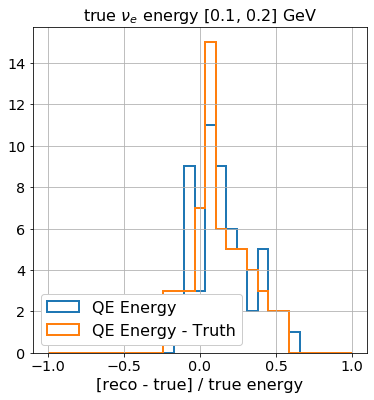

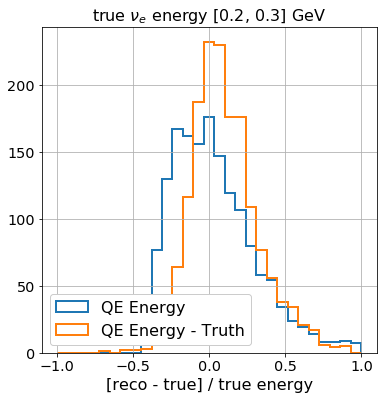

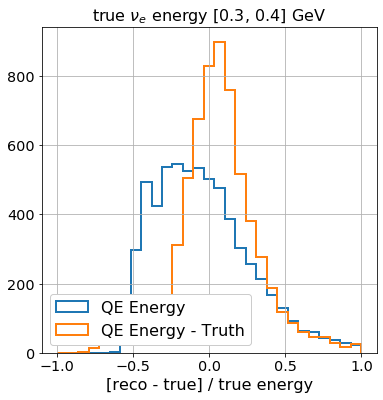

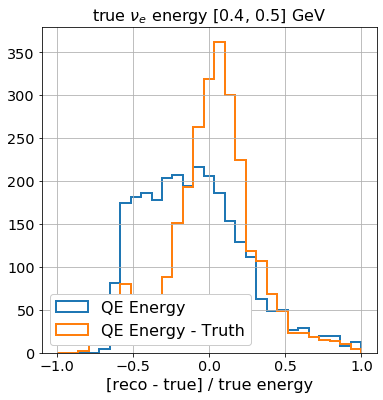

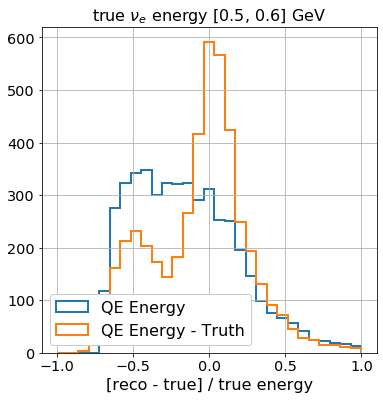

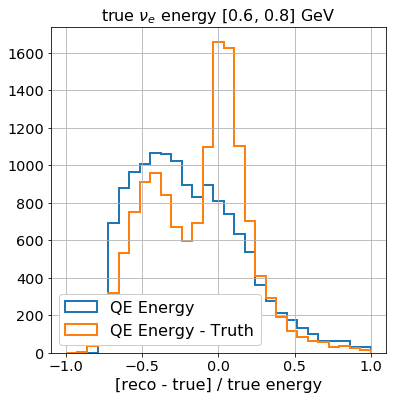

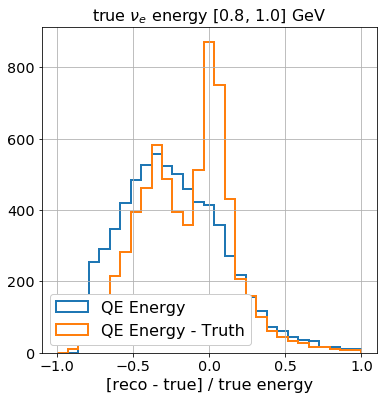

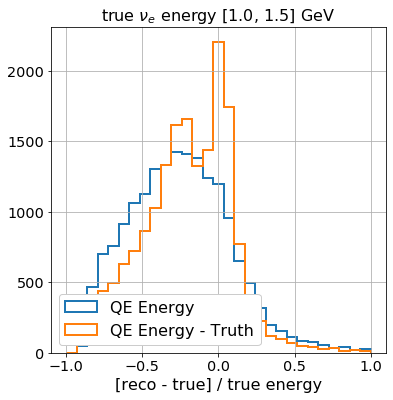

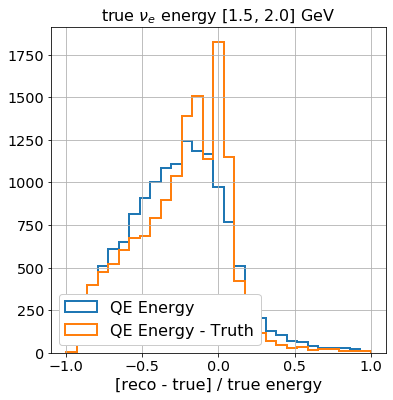

In [22]:
ERANGE_V = []

ERANGE_V = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0,1.5,2.0]


for n in range(len(ERANGE_V)-1):
    
    EMIN = ERANGE_V[n]
    EMAX = ERANGE_V[n+1]

    nue_SEL_tmp = nue_SEL.query('nu_e > %f and nu_e < %f'%(EMIN,EMAX))

    fig = plt.figure(figsize=(6,6))
    BINS = np.linspace(-1,1,30)
    #plt.hist(nue_SEL_tmp['eresclo'].values,bins=BINS,histtype='step',lw=2,label='Calorimetric Energy')
    #plt.hist(nue_SEL_tmp['eresvis'].values,bins=BINS,histtype='step',lw=2,label='Calorimetric Energy [hermeticity]')
    plt.hist(nue_SEL_tmp['eresqe'].values,bins=BINS,histtype='step',lw=2,label='QE Energy')
    plt.hist(nue_SEL_tmp['eresqetruth'].values,bins=BINS,histtype='step',lw=2,label='QE Energy - Truth')
    plt.grid()
    plt.legend(loc=3,framealpha=1,fontsize=16)
    plt.xlabel('[reco - true] / true energy',fontsize=16)
    plt.title(r'true $\nu_e$ energy [%.01f, %.01f] GeV'%(EMIN,EMAX),fontsize=16)
    plt.show()

No handles with labels found to put in legend.


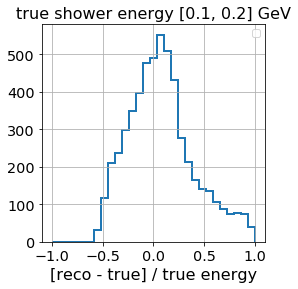

No handles with labels found to put in legend.


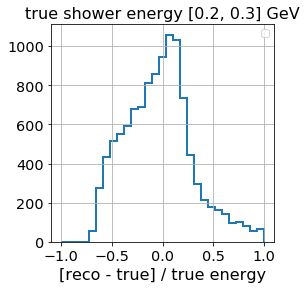

No handles with labels found to put in legend.


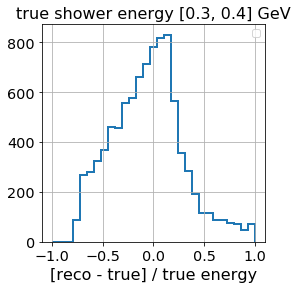

No handles with labels found to put in legend.


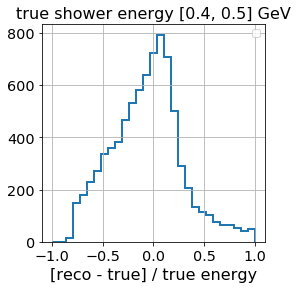

No handles with labels found to put in legend.


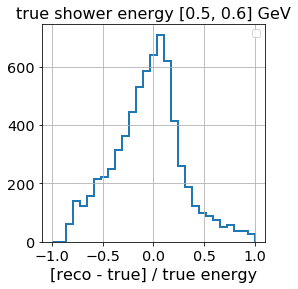

No handles with labels found to put in legend.


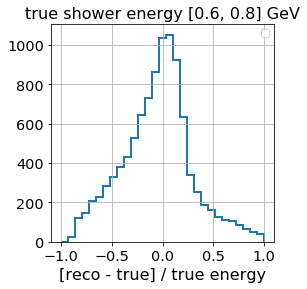

No handles with labels found to put in legend.


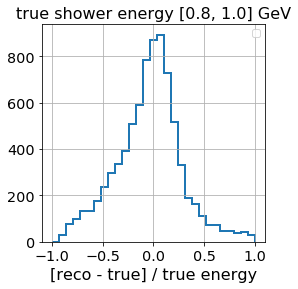

No handles with labels found to put in legend.


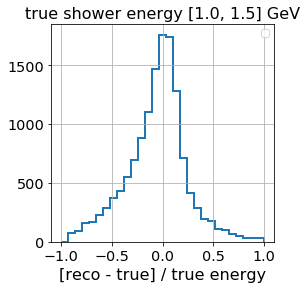

No handles with labels found to put in legend.


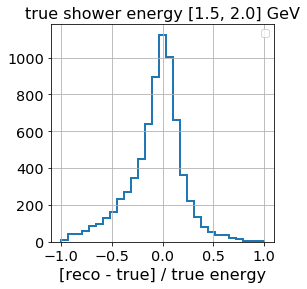

In [40]:
ERANGE_V = []

ERANGE_V = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0,1.5,2.0]


for n in range(len(ERANGE_V)-1):
    
    EMIN = ERANGE_V[n]
    EMAX = ERANGE_V[n+1]

    nue_SEL_tmp = nue_SEL.query('elec_e > %f and elec_e < %f'%(EMIN,EMAX))

    fig = plt.figure(figsize=(4,4))
    BINS = np.linspace(-1,1,30)
    plt.hist(nue_SEL_tmp['shrres'].values,bins=BINS,histtype='step',lw=2)#,label='Calorimetric Energy')
    plt.grid()
    plt.legend(loc=1)
    plt.xlabel('[reco - true] / true energy',fontsize=16)
    plt.title('true shower energy [%.01f, %.01f] GeV'%(EMIN,EMAX),fontsize=16)
    plt.show()

No handles with labels found to put in legend.


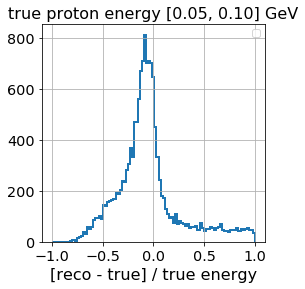

No handles with labels found to put in legend.


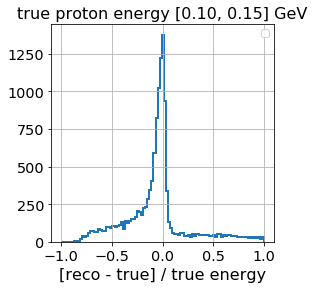

No handles with labels found to put in legend.


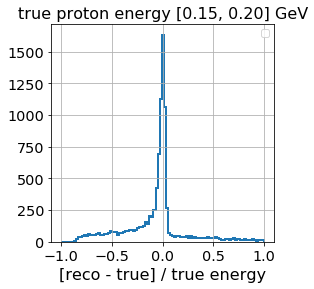

No handles with labels found to put in legend.


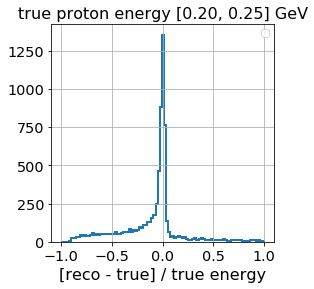

No handles with labels found to put in legend.


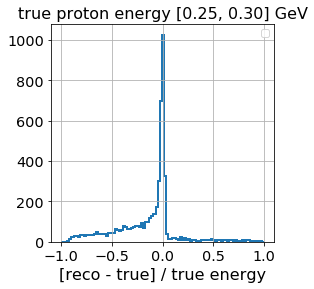

No handles with labels found to put in legend.


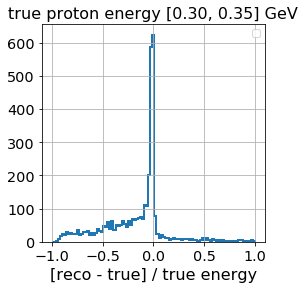

No handles with labels found to put in legend.


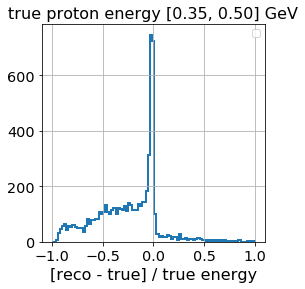

In [41]:
ERANGE_V = []

ERANGE_V = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.5]


for n in range(len(ERANGE_V)-1):
    
    EMIN = ERANGE_V[n]
    EMAX = ERANGE_V[n+1]

    nue_SEL_tmp = nue_SEL.query('proton_e > %.02f and proton_e < %.02f'%(EMIN+0.938,EMAX+0.938))

    fig = plt.figure(figsize=(4,4))
    BINS = np.linspace(-1,1,100)
    plt.hist(nue_SEL_tmp['protonres'].values,bins=BINS,histtype='step',lw=2)#,label='Calorimetric Energy')
    plt.grid()
    plt.legend(loc=1)
    plt.xlabel('[reco - true] / true energy',fontsize=16)
    plt.title('true proton energy [%.02f, %.02f] GeV'%(EMIN,EMAX),fontsize=16)
    plt.show()

In [42]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        #print bincut
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

In [43]:
# nue pre-selection
BOXCUTS = 'nslice == 1'
BOXCUTS += ' and selected == 1'
BOXCUTS += ' and n_tracks_contained > 0'
BOXCUTS += ' and shr_energy_tot_cali > 0.07'
BOXCUTS += ' and n_tracks_contained > 0'
# Loose box cuts
BOXCUTS += ' and n_showers_contained == 1'
BOXCUTS += ' and hits_ratio > 0.5'
BOXCUTS += ' and tksh_distance < 6.0'
BOXCUTS += ' and shr_tkfit_2cm_dedx_Y < 4.0'
BOXCUTS += ' and tksh_angle > -0.9'
BOXCUTS += ' and trkpid < 0.1'
BOXCUTS += ' and shr_score < 0.30'
BOXCUTS += ' and CosmicIP > 20.'
# Box cuts
BOXCUTS += ' and tksh_distance < 3.5'
BOXCUTS += ' and (shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)'
BOXCUTS += ' and (shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)'
BOXCUTS += ' and tksh_angle > -0.9 and tksh_angle < 0.7'
BOXCUTS += ' and shrmoliereavg > 2 and shrmoliereavg < 9'
BOXCUTS += ' and trkpid < -0.02'
BOXCUTS += ' and n_showers_contained == 1'
BOXCUTS += ' and shr_score < 0.275'
BOXCUTS += ' and hits_ratio > 0.60'
BOXCUTS += ' and CosmicIP > 20.'
BOXCUTS += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
BOXCUTS += ' and (trkfit < 0.45 or subcluster > 6)'

In [49]:
PRESEL = 'nslice == 1'
PRESEL += ' and selected == 1'
PRESEL += ' and n_tracks_contained > 0'
PRESEL += ' and shr_energy_tot_cali > 0.07'
PRESEL += ' and trkpid < -0.02'

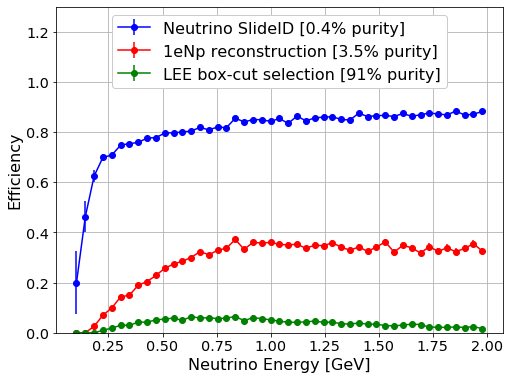

In [50]:
fig = plt.figure(figsize=(8,6))
B = np.linspace(0.0,2.0,50)

ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and nproton > 0'
#QUERY = SELQUERY
VAR = 'nu_e' #'_pi0_e'

centers,vals,errs = Eff(nue,VAR,'nslice==1',ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='b',label='Neutrino SlideID [0.4% purity]')

centers,vals,errs = Eff(nue,VAR,PRESEL,ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='r',label='1eNp reconstruction [3.5% purity]')

centers,vals,errs = Eff(nue,VAR,BOXCUTS,ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='g',label='LEE box-cut selection [91% purity]')

plt.xlabel(r'Neutrino Energy [GeV]',fontsize=16)
plt.ylabel(r'Efficiency',fontsize=16)
plt.grid()
plt.ylim([0,1.3])
plt.legend(loc=9,fontsize=16,framealpha=1.0)
#plt.yscale('log')
#plt.title(r'v08_00_00_26 Run1 Samples')
#plt.legend(loc=7,fontsize=14)
plt.show()

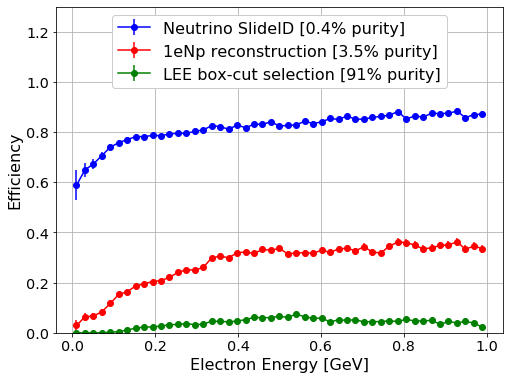

In [51]:
fig = plt.figure(figsize=(8,6))
B = np.linspace(0.0,1.0,50)

ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and nproton > 0'
#QUERY = SELQUERY
VAR = 'elec_e' #'_pi0_e'

centers,vals,errs = Eff(nue,VAR,'nslice==1',ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='b',label='Neutrino SlideID [0.4% purity]')

centers,vals,errs = Eff(nue,VAR,PRESEL,ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='r',label='1eNp reconstruction [3.5% purity]')

centers,vals,errs = Eff(nue,VAR,BOXCUTS,ACCEPTANCE,B)
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='g',label='LEE box-cut selection [91% purity]')

plt.xlabel(r'Electron Energy [GeV]',fontsize=16)
plt.ylabel(r'Efficiency',fontsize=16)
plt.grid()
plt.ylim([0,1.3])
plt.legend(loc=9,fontsize=16,framealpha=1.0)
#plt.yscale('log')
#plt.title(r'v08_00_00_26 Run1 Samples')
#plt.legend(loc=7,fontsize=14)
plt.show()

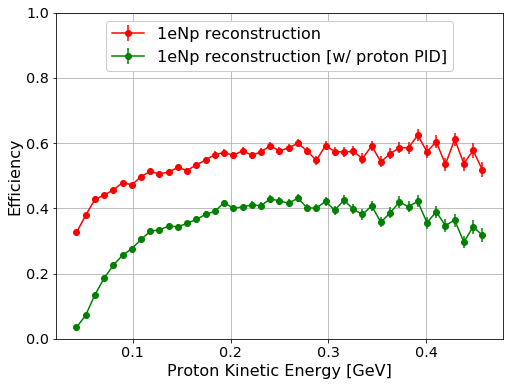

In [55]:
fig = plt.figure(figsize=(8,6))
B = np.linspace(0.938,1.4,50)

ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and nproton > 0'
#QUERY = SELQUERY
VAR = 'proton_e' #'_pi0_e'


PRESEL = 'nslice == 1'
PRESEL += ' and selected == 1'
PRESEL += ' and n_tracks_contained > 0'
PRESEL += ' and shr_energy_tot_cali > 0.07'

centers,vals,errs = Eff(nue,VAR,PRESEL,ACCEPTANCE,B)
centers -= 0.938
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='r',label='1eNp reconstruction')

PRESEL = 'nslice == 1'
PRESEL += ' and selected == 1'
PRESEL += ' and n_tracks_contained > 0'
PRESEL += ' and shr_energy_tot_cali > 0.07'
PRESEL += ' and trkpid < -0.02'

centers,vals,errs = Eff(nue,VAR,PRESEL,ACCEPTANCE,B)
centers -= 0.938
plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='g',label='1eNp reconstruction [w/ proton PID]')

plt.xlabel(r'Proton Kinetic Energy [GeV]',fontsize=16)
plt.ylabel(r'Efficiency',fontsize=16)
plt.grid()
plt.ylim([0,1.0])
plt.legend(loc=9,fontsize=16,framealpha=1.0)
#plt.yscale('log')
#plt.title(r'v08_00_00_26 Run1 Samples')
#plt.legend(loc=7,fontsize=14)
plt.show()